In [1]:
from IPython.display import display
from IPython.display import Markdown
from IPython.display import Math
from IPython.display import HTML
from IPython import display as display_as

def print_md(*args, sep = ' ', end = '\n'):    
    text = sep.join(list([str(arg) for arg in args])) + (end if end != '\n' else '')
    display(Markdown(text))

# to use whole screen
display(HTML("<style>.container { width:100% !important; }</style>"))


In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from pprint import pprint
%matplotlib inline


In [3]:
%pwd 
%ls

 Volume in drive E is STORAGE
 Volume Serial Number is CE17-509E

 Directory of E:\4.Docs\11.Projects\777.Jupyter

12/11/2023  09:13 PM    <DIR>          .
12/11/2023  09:13 PM    <DIR>          ..
12/06/2023  11:13 PM    <DIR>          .ipynb_checkpoints
12/11/2023  09:13 PM           970,088 makemore_part3.ipynb
12/06/2023  10:23 PM           228,145 names.txt
               2 File(s)      1,198,233 bytes
               3 Dir(s)  5,152,841,641,984 bytes free


In [4]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [5]:
len(words)

32033

In [6]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
pprint(itos)
print()
print(f'Vocab size: {vocab_size}')

{0: '.',
 1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z'}

Vocab size: 27


In [7]:
#building dataset 
block_size = 3  #context length: how many chars do we take to predict the next character

def build_dataset(words):
    X, Y = [], []
    #
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

# spliting dataset to training, validation(dev), test sets
import random
random.seed(42)
random.shuffle(words)

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2]) # 10%
Xte, Yte = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [8]:
# to improve initialization, we've made the corrections:
# since the logits agre generated at logits = h @ W2 + b
# and we want logits to be more uniform at the init
# and closer to 0
# we are setting b2 biases to 0
# also we can multiply W2 by 0.1 or even 0.01 at init and make it smaller
# now at first iteration we are getting Iteration:       0/ 200000: 4.2326
# We didnt set W2 to 0, because things may go wrong ( dead neurons? oversaturation? symmetry? )
# in case of 0.01 multiplicator ( instead of 0) the loss is close enough to 
# -torch.tensor(1/27.0).log() = tensor(3.2958)
# but still has some entropy (loss or weights?)
# which is useful for symmetry breaking during training
# logits are closer to 0 now
# logits[0] = tensor([-0.0249,  0.3523, -0.1267,  0.0541,  0.1662, -0.1171, -0.0140,  0.0124,
#                      0.0921,  0.1135,  0.1362, -0.0925,  0.0444, -0.2459, -0.0971,  0.0125,
#                     -0.0957, -0.1376, -0.2329, -0.0137,  0.2452,  0.1616,  0.1665, -0.1094,
#                     -0.2154,  0.0725,  0.1141], grad_fn=<SelectBackward0>)
# 0th row...
# And  after that we got a slightly improved result
# Because we are spending more cycles for actual optimization,
# instead of squashing down the weights, to make them not as huge as they are initialized
# 

In [9]:
#setting parameters for Multi-layer perceptron
n_embd = 10 # the dimentionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd*block_size, n_hidden),  generator=g) 
b1 = torch.randn(n_hidden,                       generator=g)  # to not have dead neutons in the tanh layer
W2 = torch.randn((n_hidden, vocab_size),         generator=g) * 0.01 # the same, as for b2, just bringing weights closer to 0 at initialization
b2 = torch.randn(vocab_size,                     generator=g) * 0  # zeroed out the b2, so logits come out closer to 0, and we have lower loss

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters total
for p in parameters:
    p.requires_grad = True

11897


In [10]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    #minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # FORWARD PASS
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # BACWARD PASS
    for p in parameters:
        p.grad = None
    loss.backward()

    # UPDATE WEIGHTS
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    if not i % 10000 or i == 199999:
        print(f'\rIteration: {i:7d}/{max_steps:7d}: {loss.item():.4f}', flush=True, end='')
    lossi.append(loss.log10().item())
    

Iteration:  199999/ 200000: 2.3703

In [11]:
# if we inspect the logits at initialization 
# we'll see them taking quite extreme values
# and this is what's causes a huge loss 27.8817 at the beginning
# the logits must be closer to 0
# logits[0]
h
# tensor([ -2.3527,  36.4366, -10.7306,   5.7165,  18.6409, -11.6998,  -2.1991,
#           1.8535,  10.9996,  10.6730,  12.3507, -10.3809,   4.7243, -24.4257,
#          -8.5909,   1.9024, -12.2744, -12.4751, -23.2778,  -2.0163,  25.8767,
#          14.2108,  17.7691, -10.9204, -20.7335,   6.4560,  11.1615],
#        grad_fn=<SelectBackward0>)
# after hardcoding initialization, the logits are much closer to 0

tensor([[ 0.7100, -0.7878, -0.7424,  ..., -1.0000,  1.0000,  1.0000],
        [-0.5616, -1.0000, -1.0000,  ..., -0.8078,  0.9971, -0.9209],
        [-1.0000,  0.9940, -1.0000,  ...,  0.3852, -0.9303,  0.3262],
        ...,
        [-0.9992, -1.0000, -0.9999,  ..., -0.4351, -0.8976, -0.3768],
        [ 0.9939,  0.8976,  1.0000,  ..., -0.9538, -1.0000,  0.9987],
        [-1.0000, -0.9995, -1.0000,  ..., -0.6407, -0.8208,  0.5101]],
       grad_fn=<TanhBackward0>)

In [12]:
# at initialization, there is 27 characters & we have no reason to believe 
# any character is more likely than others 
# so as we would assign about equal probability to
# all the 27 characters at initialization
# and since we are taking log scale ( negative log likelihood)
# we expect this loss at the beginning:
-torch.tensor(1/27.0).log()
# which i much lower than we had, when initializaed the biases at randn


tensor(3.2958)

In [13]:
# 4D example of the issue:
logits = torch.tensor([0.0, 0.0, 0.0, 0.0])
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
probs, loss
# if logits are all close to 0, or to the same number (label)
# after softmax we are gitting the diffused distribution and low loss
# (tensor([0.2500, 0.2500, 0.2500, 0.2500]), tensor(1.3863))


# if we assign a correct probability to the correct lable by chance
# at initialization, we'll have low loss
# e.g. is logits = torch.tensor([0.0, 0.0, 5.0, 0.0])
# loss = 0.2 here
# sm: tensor([0.0066, 0.0066, 0.9802, 0.0066])



(tensor([0.2500, 0.2500, 0.2500, 0.2500]), tensor(1.3863))

In [14]:
# 4D example of the issue:

# but much more likely, that some other element (dimention) 
# will have a high logit, and we'll start recording much higher loss
#  
logits = torch.tensor([-3.0, 5.0, 0.0, 2.0])
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
probs, loss

(tensor([3.1741e-04, 9.4620e-01, 6.3754e-03, 4.7108e-02]), tensor(5.0553))

In [15]:
# 4D example of the issue:

# if we have torch.randn it is more or less ok
logits = torch.randn(4)
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
logits, probs, loss

(tensor([0.4766, 0.5553, 1.0525, 0.6366]),
 tensor([0.1986, 0.2149, 0.3533, 0.2331]),
 tensor(1.0404))

In [16]:
# but suppose this is * 10
# 
logits = torch.randn(4) * 200
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
logits, probs, loss

# since the values are quite extreme, it is unlikely we'll guess the correct pocket.
# and we'll be "Confidently wrong" with high loss
# and if logits become even more extreme, we'll have  tensor(inf)) losses...
# SO The logits must be at least roughly equal, or much closer to each other...
# due to "symetry " ( idk what he meant here)
# we don't want the logits to be any positive or negative number
# and we want them all be closer to 0

(tensor([ -77.7177, -275.2015, -122.5467,   39.3469]),
 tensor([0., 0., 0., 1.]),
 tensor(inf))

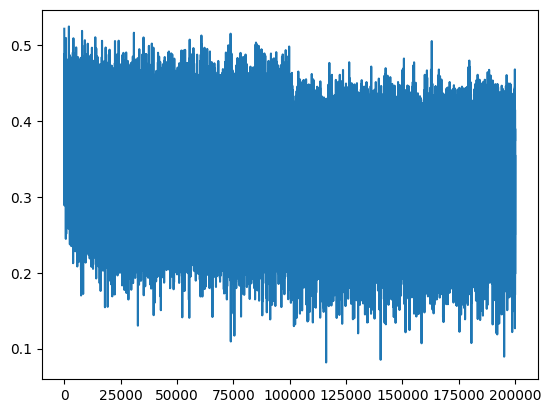

In [17]:
plt.plot(lossi)

In [18]:
@torch.no_grad() # the decorator disables gradient tracking
def split_loss(split):
    x,y = {
        'train': {Xtr, Ytr},
        'val': {Xdev, Ydev},
        'test': {Xte, Yte},
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) #concat into (N, block_size * n_embd)
    h = torch.tanh(embcat @ W1 + b1) # (N, n_hidden)
    logits = h @ W2 + b2 # N, vocab_size
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.069589138031006
val 2.131075143814087


In [19]:
# SAMPLING FROM THE MODEL:

g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size # initialize with all symbols ...
    while True:
        # FORWARD PASS the NN
        emb = C[torch.tensor([context])] # (1, block_size, n_embd)
        h = torch.tanh(emb.view(1,-1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        # SAMPLE FROM THE DISTRIBUTION
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if sample contains '.' token, break
        if ix == 0:
            break
            
    print(''.join(itos[i] for i in out)) # decode and print the generated word

mora.
mayah.
seel.
ndyn.
alerethruthadrie.
cadelyn.
elin.
shi.
jen.
eden.
est.
aarvelyzion.
kamin.
shub.
roshimies.
kin.
renlynn.
novana.
ubeen.
der.


In [20]:
# TANH SATURATION


In [21]:
#setting parameters for Multi-layer perceptron
n_embd = 10 # the dimentionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd*block_size, n_hidden),  generator=g) 
b1 = torch.randn(n_hidden,                       generator=g)  # to not have dead neutons in the tanh layer
W2 = torch.randn((n_hidden, vocab_size),         generator=g) * 0.01 # the same, as for b2, just bringing weights closer to 0 at initialization
b2 = torch.randn(vocab_size,                     generator=g) * 0  # zeroed out the b2, so logits come out closer to 0, and we have lower loss

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters total
for p in parameters:
    p.requires_grad = True

11897


In [22]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    #minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # FORWARD PASS
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # BACWARD PASS
    for p in parameters:
        p.grad = None
    loss.backward()

    # UPDATE WEIGHTS
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    if not i % 10000 or i == 199999:
        print(f'\rIteration: {i:7d}/{max_steps:7d}: {loss.item():.4f}', flush=True, end='')        
    
    lossi.append(loss.log10().item())
    break

Iteration:       0/ 200000: 3.3221

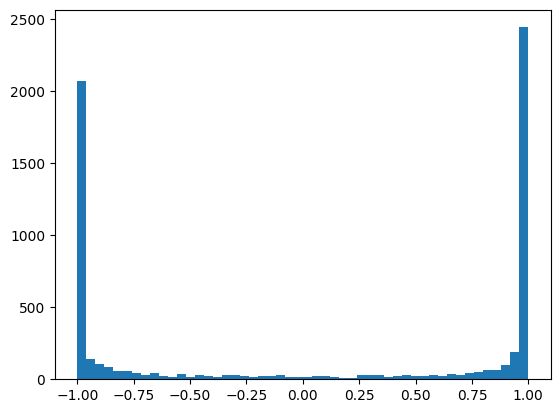

In [23]:
#analysing h with histogram
plt.hist(h.view(-1).tolist(), 50);
# most of values are  -1 and 1 - saturation

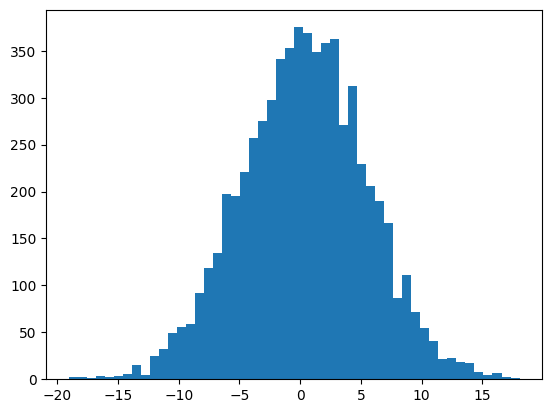

In [24]:
# we can also look at preactivation that feed to tanh
plt.hist(hpreact.view(-1).tolist(), 50);
# preactivations are very broad
# 

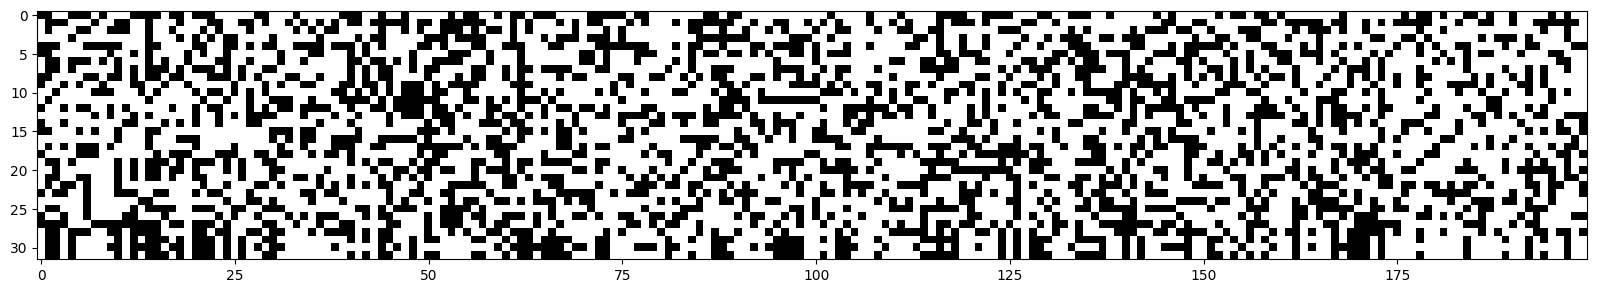

In [25]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

In [26]:
@torch.no_grad() # the decorator disables gradient tracking
def split_loss(split):
    x,y = {
        'train': {Xtr, Ytr},
        'val': {Xdev, Ydev},
        'test': {Xte, Yte},
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) #concat into (N, block_size * n_embd)
    h = torch.tanh(embcat @ W1 + b1) # (N, n_hidden)
    logits = h @ W2 + b2 # N, vocab_size
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 3.1878931522369385
val 3.187795877456665


In [27]:
#FIXING SATURATED TANH

In [28]:
#setting parameters for Multi-layer perceptron
n_embd = 10 # the dimentionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd*block_size, n_hidden),  generator=g) * 0.2
b1 = torch.randn(n_hidden,                       generator=g) * 0.01 # to not have dead neutons in the tanh layer
W2 = torch.randn((n_hidden, vocab_size),         generator=g) * 0.01 # the same, as for b2, just bringing weights closer to 0 at initialization
b2 = torch.randn(vocab_size,                     generator=g) * 0  # zeroed out the b2, so logits come out closer to 0, and we have lower loss

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters total
for p in parameters:
    p.requires_grad = True

11897


In [29]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    #minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # FORWARD PASS
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # BACWARD PASS
    for p in parameters:
        p.grad = None
    loss.backward()

    # UPDATE WEIGHTS
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    if not i % 10000 or i == 199999:
        print(f'\rIteration: {i:7d}/{max_steps:7d}: {loss.item():.4f}', flush=True, end='')        
    
    lossi.append(loss.log10().item())
    break

Iteration:       0/ 200000: 3.3135

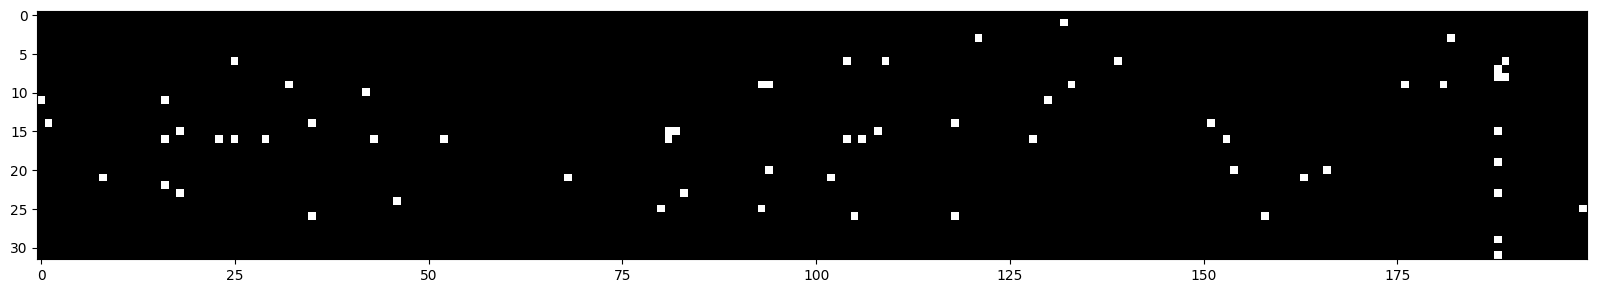

In [30]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

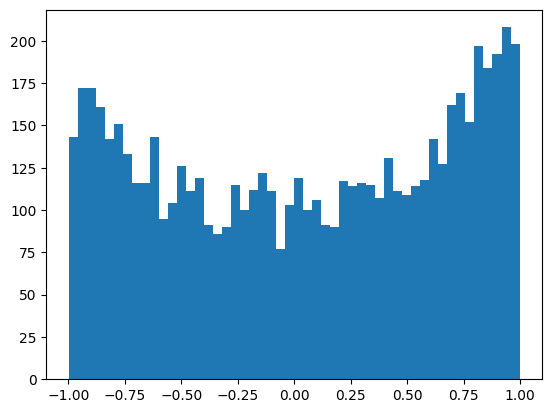

In [31]:
#analysing h with histogram
plt.hist(h.view(-1).tolist(), 50);
# most of values are  -1 and 1 - saturation

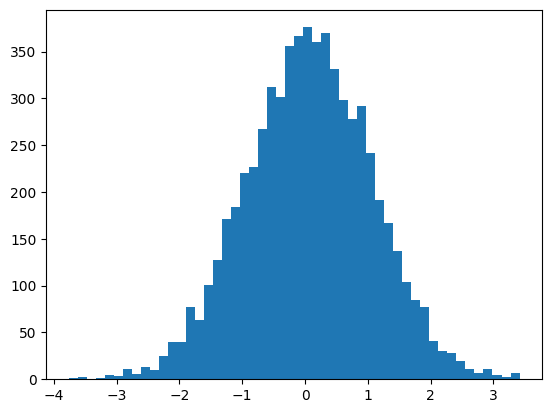

In [32]:
# we can also look at preactivation that feed to tanh
plt.hist(hpreact.view(-1).tolist(), 50);
# preactivations are very broad
# 

In [33]:
@torch.no_grad() # the decorator disables gradient tracking
def split_loss(split):
    x,y = {
        'train': {Xtr, Ytr},
        'val': {Xdev, Ydev},
        'test': {Xte, Yte},
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) #concat into (N, block_size * n_embd)
    h = torch.tanh(embcat @ W1 + b1) # (N, n_hidden)
    logits = h @ W2 + b2 # N, vocab_size
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 3.241575002670288
val 3.241713285446167


In [34]:
# trying full optimization with no break, after hand-correcting W1, b1, W2, b2

In [35]:
#setting parameters for Multi-layer perceptron
n_embd = 10 # the dimentionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd*block_size, n_hidden),  generator=g) * 0.2
b1 = torch.randn(n_hidden,                       generator=g) * 0.01 # to not have dead neutons in the tanh layer
W2 = torch.randn((n_hidden, vocab_size),         generator=g) * 0.01 # the same, as for b2, just bringing weights closer to 0 at initialization
b2 = torch.randn(vocab_size,                     generator=g) * 0  # zeroed out the b2, so logits come out closer to 0, and we have lower loss

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters total
for p in parameters:
    p.requires_grad = True

11897


In [36]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    #minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # FORWARD PASS
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # BACWARD PASS
    for p in parameters:
        p.grad = None
    loss.backward()

    # UPDATE WEIGHTS
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    if not i % 10000 or i == 199999:
        print(f'\rIteration: {i:7d}/{max_steps:7d}: {loss.item():.4f}', flush=True, end='')        
    
    lossi.append(loss.log10().item())
    

Iteration:  199999/ 200000: 2.4017

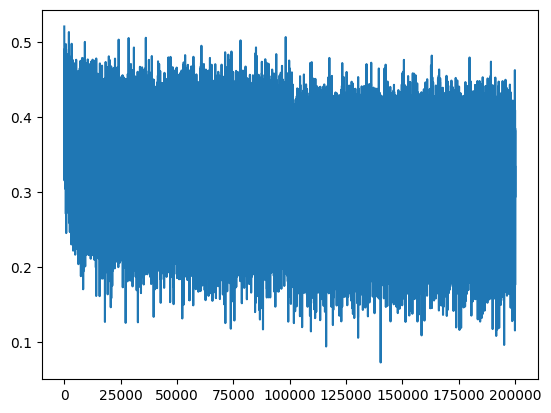

In [37]:
plt.plot(lossi)

In [38]:
@torch.no_grad() # the decorator disables gradient tracking
def split_loss(split):
    x,y = {
        'train': {Xtr, Ytr},
        'val': {Xdev, Ydev},
        'test': {Xte, Yte},
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) #concat into (N, block_size * n_embd)
    h = torch.tanh(embcat @ W1 + b1) # (N, n_hidden)
    logits = h @ W2 + b2 # N, vocab_size
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0355966091156006
val 2.1026785373687744


In [39]:
# for  larger Neural Networks the problems like
# "tanh saturation" or softmax "confidently wrong",
# or the "dead neurons" - these problems may stack up on each other
# and things get more complicated
# The deeper the network and the more complex it is
# the less forgiving it is to some of these errors
# BE AWARE ! SCRUTINIZE ! PLOT ! BE CAREFUL WITH THESE ERRORS!
# 


In [40]:
# finding right mupltipliers for the initialization

In [41]:
#setting parameters for Multi-layer perceptron
n_embd = 10 # the dimentionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd*block_size, n_hidden),  generator=g) * 0.2
b1 = torch.randn(n_hidden,                       generator=g) * 0.01 # to not have dead neutons in the tanh layer
W2 = torch.randn((n_hidden, vocab_size),         generator=g) * 0.01 # the same, as for b2, just bringing weights closer to 0 at initialization
b2 = torch.randn(vocab_size,                     generator=g) * 0  # zeroed out the b2, so logits come out closer to 0, and we have lower loss

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters total
for p in parameters:
    p.requires_grad = True

11897


tensor(0.0223) tensor(1.0044)
tensor(0.0093) tensor(3.0335)


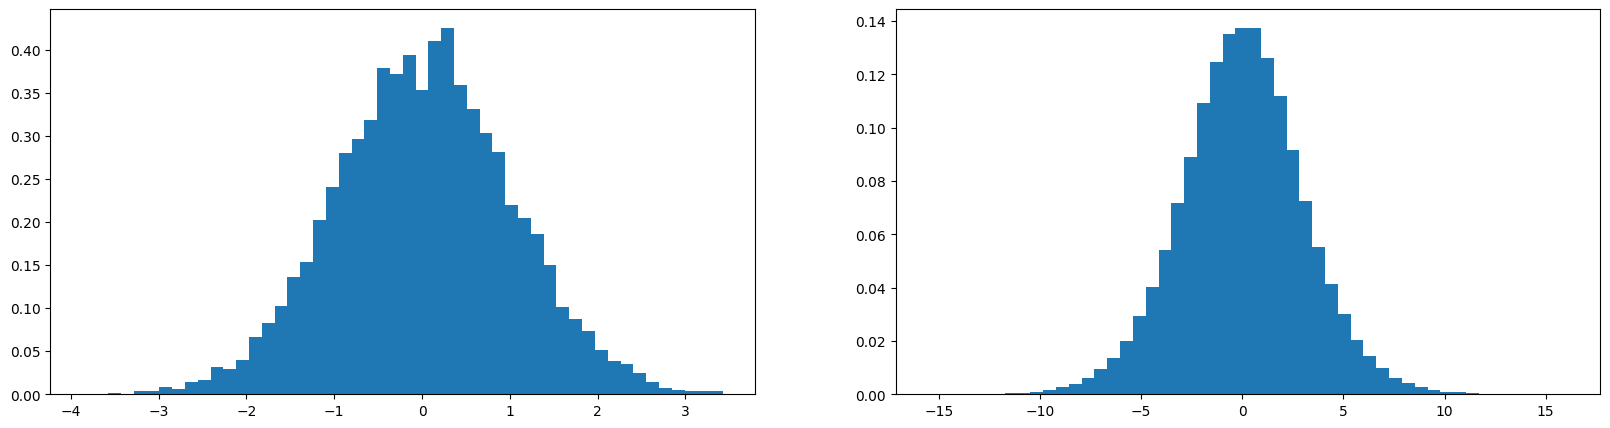

In [42]:
x = torch.randn(1000,10)
w = torch.randn(10,200)
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())

plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);

tensor(-0.0074) tensor(0.9880)
tensor(0.0013) tensor(0.9222)


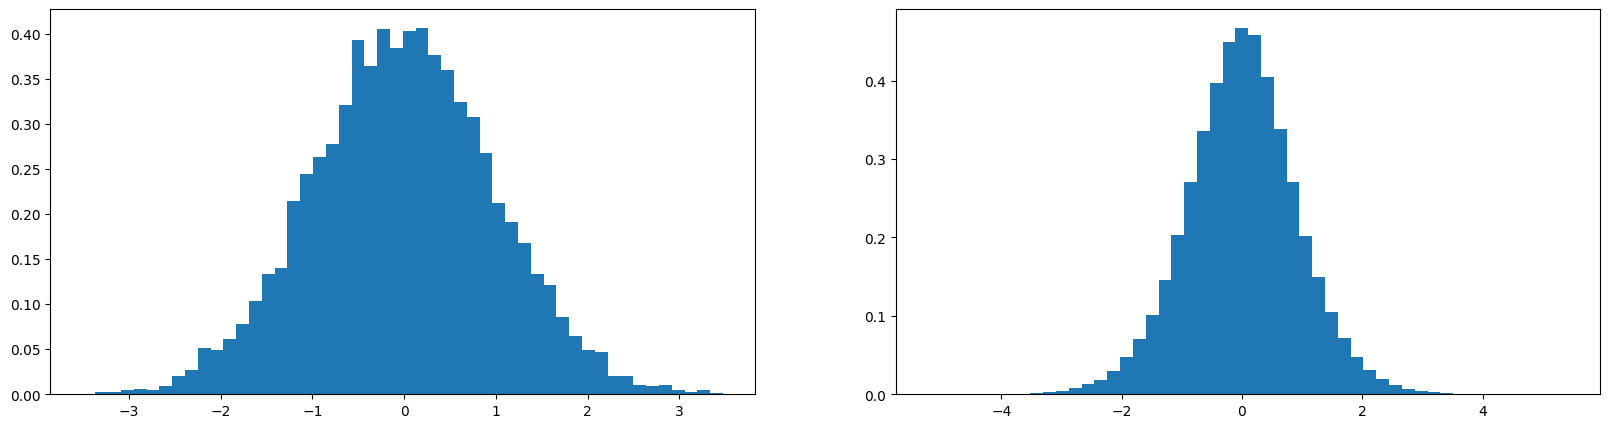

In [43]:
# after the dot product std become 3, instead of 1,
# which is what we dont want
# so we can scale w down

x = torch.randn(1000,10)
w = torch.randn(10,200) * 0.3
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())

plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);

tensor(0.0115) tensor(1.0035)
tensor(0.0011) tensor(1.0044)


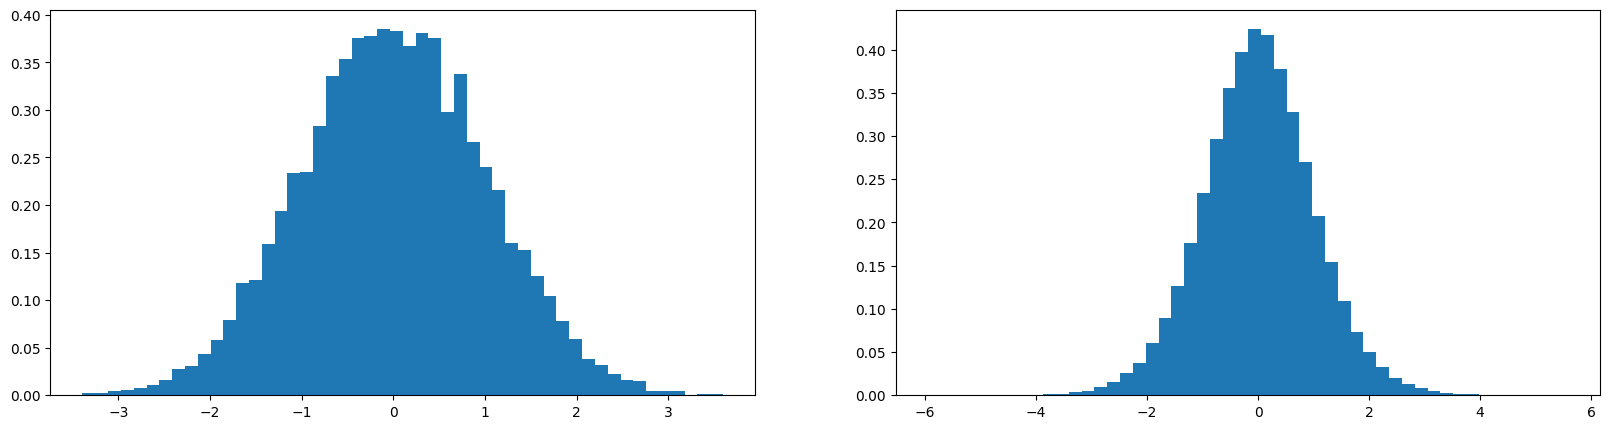

In [44]:
# we can calculate this scalar to multiply w by the right amount
# we need to use 1 / sqrt(fan_in) (which is amount of raws in w, or columns in x)
# to achieve y with std ~ 1

from math import sqrt

fan_in = 10
x = torch.randn(1000,fan_in)
w = torch.randn(fan_in,200) / sqrt(fan_in)   # here are tha changes
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())

plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);

In [45]:
# one important paper to initializaton is
# Delving Deep into rectifiers:
# Surpassing Human-Level Performance on ImageNet Classification by Kaiming He, Xiangyu Zhang 
# it states that for the reason we throwing away part ( for ReLU 1/2 ) of the distribution with 
# activation function ( which is squasing data)
# we have to compensate for this with a "gain"
# for ReLU, they found that we need to initialize NN weights
# with a 0-mean random numbers with gaussian distribution, with std = sqrt(2/nj), where
# nj - is fan_in (dimentionality of the input vector, that goes to NN (or a layer))
# The same paper Also did analysis on the backprop gradients
# they found that if Forward pass appropriately initialized,
# the backward pass will be also approximately properly initialized
# up to a constant factor, that depends on the size and number of hidden neurons 
# but this matters less than the forward pass
# PyTorh has kaimin_normal, and it is the most common way to initialize NN
# depending on nonlinearity, gain will differ

# for kaiming normal:
display(Math(r'std = \frac{gain}{\sqrt{fan\_mode}};'))
# fan_mode either fan_in, for activations or fan_out for backprop gradients
# for me fan_mode == fan_in - input dumentionality

# if no nonlinearity
display(Math(r'gain = 1; \ \ \ \ \ \  (for\ \  linear)'))
display(Math(r'gain = 1; \ \ \ \ \ \  (for\ \  sigmoid)'))
display(Math(r'gain = \frac{5}{3}; \ \ \ \ \ \  (for\ \  tanh)'))
display(Math(r'gain = \sqrt{2}; \ \ \ \ \ \  (for\ \  ReLU)'))
display(Math(r'gain = \sqrt{\frac{2}{1+negative\_slope^2}}; \ \ \ \ \ \  (for\ \  Leaky ReLU)'))
display(Math(r'gain = \frac{3}{4}; \ \ \ \ \ \  (for\ \  SELU)'))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [46]:
# when this paper was release, we had to be careful with everything
# ranges histograms, gains, etc...
# but now there are a number of innovations that made NNs signiffucantly 
# more stable and well behaved, among these innovations are:
# Residual connections
# Normalization layers: batch normalization, layer normalization, group normalization
# better optimizers, not kust SGD: rmsprop, adam
# So Andrej recommends to normalize all the weights by sqrt(fan_in)
# or if we want to be more precscise, we can use kaiming normal... e.g.:
# w = torch.empty(3,5)
# nn.init._kaiming_normal_(w, model=fan_in, nonlinearity='tanh')
# or
# torch.randn((amont_of_examples, fan_in)) * fan_in**0.5

In [47]:
tanh_gain = (5/3) # 5/3 gain for tanh
tanh_kaiming = lambda fan_in: tanh_gain / fan_in**0.5

#setting parameters for Multi-layer perceptron
n_embd = 10 # the dimentionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd*block_size, n_hidden),  generator=g) * tanh_kaiming(n_embd*block_size)   # used to be, when we made a guess 0.2, now we calculate it more prescisely
b1 = torch.randn(n_hidden,                       generator=g) * tanh_kaiming(n_embd*block_size) # to not have dead neutons in the tanh layer
W2 = torch.randn((n_hidden, vocab_size),         generator=g) * 0.01 # the same, as for b2, just bringing weights closer to 0 at initialization
b2 = torch.randn(vocab_size,                     generator=g) * 0  # zeroed out the b2, so logits come out closer to 0, and we have lower loss

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters total
for p in parameters:
    p.requires_grad = True


11897


tensor(0.0039, grad_fn=<MeanBackward0>) tensor(0.3107, grad_fn=<StdBackward0>)
tensor(0.0058, grad_fn=<MeanBackward0>) tensor(0.3114, grad_fn=<StdBackward0>)


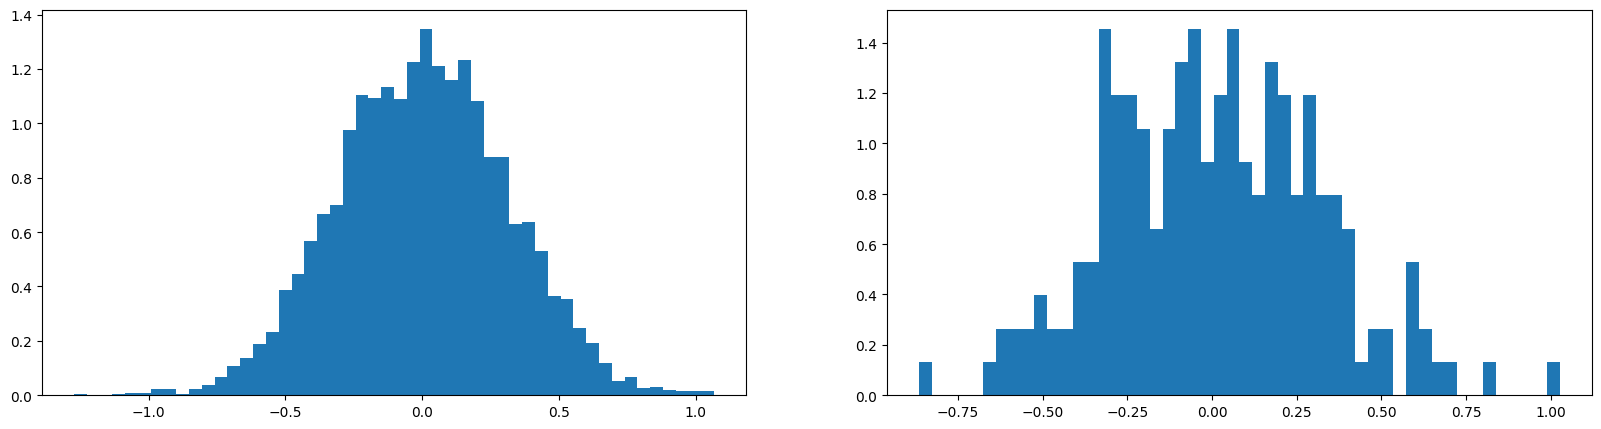

In [48]:
print(W1.mean(), W1.std())
print(b1.mean(), b1.std())

plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(W1.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(b1.view(-1).tolist(), 50, density=True);
# for some reason std != 1 here, maybe we want 1 to be hpreact, idk

In [49]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    #minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # FORWARD PASS
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # BACWARD PASS
    for p in parameters:
        p.grad = None
    loss.backward()

    # UPDATE WEIGHTS
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    if not i % 10000 or i == 199999:
        print(f'\rIteration: {i:7d}/{max_steps:7d}: {loss.item():.4f}', flush=True, end='')        
    
    lossi.append(loss.log10().item())
    

Iteration:  199999/ 200000: 2.3249

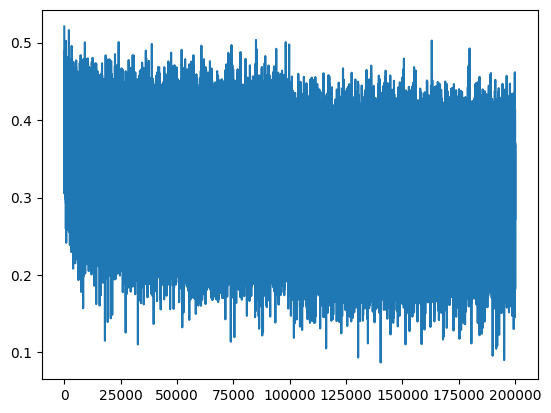

In [50]:
plt.plot(lossi)

In [51]:
@torch.no_grad() # the decorator disables gradient tracking
def split_loss(split):
    x,y = {
        'train': {Xtr, Ytr},
        'val': {Xdev, Ydev},
        'test': {Xte, Yte},
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) #concat into (N, block_size * n_embd)
    h = torch.tanh(embcat @ W1 + b1) # (N, n_hidden)
    logits = h @ W2 + b2 # N, vocab_size
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0376381874084473
val 2.1056149005889893


In [52]:
# BATCH NORMALIZATION:
# was introduced in 2015 paper
# Batch Normalization: accelerating Deep Network Training 
# by reducing Internal Covariate Shift
# by Sergey Ioffe & Christian Szegedy Google Inc.
# The paper allowed to train deep neural nets reliably

# main idea is that we need to make preactivations
# to have roughly gaussian distribution

In [53]:
tanh_gain = (5/3) # 5/3 gain for tanh
tanh_kaiming = lambda fan_in: tanh_gain / fan_in**0.5

#setting parameters for Multi-layer perceptron
n_embd = 10 # the dimentionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd*block_size, n_hidden),  generator=g) * tanh_kaiming(n_embd*block_size)   # used to be, when we made a guess 0.2, now we calculate it more prescisely
b1 = torch.randn(n_hidden,                       generator=g) * tanh_kaiming(n_embd*block_size) # to not have dead neutons in the tanh layer
W2 = torch.randn((n_hidden, vocab_size),         generator=g) * 0.01 # the same, as for b2, just bringing weights closer to 0 at initialization
b2 = torch.randn(vocab_size,                     generator=g) * 0  # zeroed out the b2, so logits come out closer to 0, and we have lower loss

bngain = torch.ones((1, n_hidden)) # added for allowing scaling after initialization with batch-normalization
bnbias = torch.zeros((1, n_hidden)) # added for allowing shifting after initialization with batch-normalization

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters total
for p in parameters:
    p.requires_grad = True


12297


In [54]:
# we need to calculate mean over all the elements in the batch
# hpreact.mean(0, keepdim=True) 
# so it is a mean for each input example
# and similarly we can calculate standard deviation of this activaions
# std is a square root of variance, which is sum of the distance between inputs and their means squared and averaged:
# v = σ² = 1/m sum i=1→m (xi - mean(X))²
# std = sqrt(v)
# hpreact.std(0, keepdim=True)

# So we'll subtract the mean, to "center it"
# and divide by std, to make its std = 1
# it is also called normalization via Mini-Batch Statistics

# IMPORTANT NOTE:
# in addition to the batch normalization, 
# we need it to be normalized, but only at initialization,
# and after that we want to allow backprop to scale and shift the distribution
# we don't want to force the gaussian distribution always!
# so we defined bngain and bnbias at init (this is also from the paper 2015 
# Batch Normalization: accelerating Deep Network Training by reducing Internal Covariate Shift

# also we have to add batch normalization at test time

#NOTE: batch norm helps greatly with multilayer NNs, 
# and does not give a lot of the effect to the 1-2 layer network we have here

# IMPORTANT NOTE:
# Also, due to the fact that we have added the normalization to a hidden layer ( or whatever layer )
# and data going throguh the hidden layer depends on the input
# and we use input in batches,
# so when we applied batch normalization, based on batch - statistics, of mean and std
# hpreact (or whatever the result of normalized layer), starts to "jittering" for any given example
# depending on the other examples fed in a particulat batch, because mean and std statistics are
# calculated for whole batch, and not each individual example separately.
# so the examples in the batch are becomming coupled mathematically in the forward pass.
# This jitter / noise of the hpreact (or whatever batch norm is applied to),
# interestingly at the first glance  could be seen as a bug, 
# but it benefits for the NN, because it creates some kind of the "padding"
# and it also can be viewed as a "data augmentation" for a layer, this jutter adds some entropy,
# and allows for some regularization. And it makes this harder for the NN, to overfit,
# specific example.
# NOTE: So the batch-normalization, as a second order effect, is actually a regularizer

# NOTE: no one really likes the examples in a batch to be coupled mathematically,
# so researchers are trying to deprecate batch normalization, and have something
# that doesn't couple the examples in a batch, e.g. they use:
# Layer Normalization
# Instance Normalization
# Group Normalization
# but the batch normalization is the first Norm, that was introduced, and it worked extremely well
# SO it was hard to deprecate Batch Norm, cause it works really well.

#  NOTE: Another weird outcome of the couppling examples within a batch by batch normalization
#  is thant we HAVE TO Calibrate batch normalization statistics a 
# single time after training, for the "test time" or for the actual inference

In [55]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    #minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # FORWARD PASS
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    # hpreact = (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) # batch-normalization
    hpreact = (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) # batch-normalization
    hpreact = bngain*hpreact + bnbias # added to permit bacprop to scale and shift the distribution
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # BACWARD PASS
    for p in parameters:
        p.grad = None
    loss.backward()

    # UPDATE WEIGHTS
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    if not i % 10000 or i == 199999:
        print(f'\rIteration: {i:7d}/{max_steps:7d}: {loss.item():.4f}', flush=True, end='')        
    
    lossi.append(loss.log10().item())
    

Iteration:  199999/ 200000: 2.4315

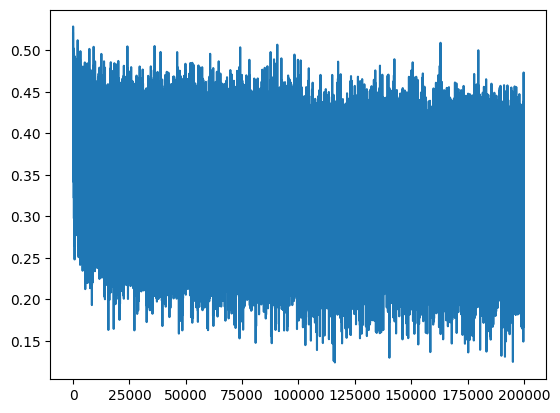

In [56]:
plt.plot(lossi)

In [57]:
# CALIBRATING BATCH NORMALIZATION STATISTICS
# THIS WIll ALLOW US TO FORWARD A SINGLE EXAMPLE
with torch.no_grad():   # don't need backward_ here
    # pass the training set through
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    # measuring the mean & std over the entire training set
    bnmean = hpreact.mean(0, keepdims=True)
    bnstd = hpreact.std(0, keepdims=True)    

In [58]:
@torch.no_grad() # the decorator disables gradient tracking
def split_loss(split):
    x,y = {
        'train': {Xtr, Ytr},
        'val': {Xdev, Ydev},
        'test': {Xte, Yte},
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) #concat into (N, block_size * n_embd)
    hpreact = embcat @ W1 + b1
    # used to be thsis, but we added a calibration above: hpreact = (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) # batch-normalization
    # so now it is:
    hpreact = (hpreact - bnmean) / bnstd # batch-normalization
    hpreact = bngain*hpreact + bnbias # added to permit bacprop to scale and shift the distribution, also added to test time
    h = torch.tanh(hpreact) # (N, n_hidden)
    logits = h @ W2 + b2 # N, vocab_size
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0668270587921143
val 2.1049270629882812


In [59]:
# FOR CALIBRATING THE Batch Normalization statistics, we can also extimate them at the train time
# as a running average
# NOTE: This is exactly how it is implemented in a  batch-norm layer of pytorch, that is part of API

In [60]:
tanh_gain = (5/3) # 5/3 gain for tanh
tanh_kaiming = lambda fan_in: tanh_gain / fan_in**0.5

#setting parameters for Multi-layer perceptron
n_embd = 10 # the dimentionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd*block_size, n_hidden),  generator=g) * tanh_kaiming(n_embd*block_size)   # used to be, when we made a guess 0.2, now we calculate it more prescisely
#b1 = torch.randn(n_hidden,                       generator=g) * tanh_kaiming(n_embd*block_size) # to not have dead neutons in the tanh layer # REMOVED DUE TO WE HAVE THIS LAYER BEING BATCH - NORMALIZED
W2 = torch.randn((n_hidden, vocab_size),         generator=g) * 0.01 # the same, as for b2, just bringing weights closer to 0 at initialization
b2 = torch.randn(vocab_size,                     generator=g) * 0  # zeroed out the b2, so logits come out closer to 0, and we have lower loss

bngain = torch.ones((1, n_hidden)) # added for allowing scaling after initialization with batch-normalization
bnbias = torch.zeros((1, n_hidden)) # added for allowing shifting after initialization with batch-normalization
# in PyTorch there is a parameter for batch norm  layer, called "affine", thatdefines, if the
# bngain and bnbias are learnable.
# in our case they are

bnmean_running = torch.zeros((1, n_hidden))   # ADDED FOR CALIBRATION AND RUNNING ESTIMATION
bnstd_running = torch.ones((1, n_hidden))     # ADDED FOR CALIBRATION AND RUNNING ESTIMATION

parameters = [C, W1, W2, b2, bngain, bnbias] # removed b1
print(sum(p.nelement() for p in parameters)) # number of parameters total
for p in parameters:
    p.requires_grad = True


12097


In [61]:
# UPDATE changes bnmean & bnmean estimation

max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    #minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # FORWARD PASS
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    # Batch normalization Layer -------------------------------------------
    # ---------------------------------------------------------------------
    hpreact = embcat @ W1 # + b1 # hidden layer pre-activation  REMOVED BIAN, CAUSE THIS S JUST A WASTE OF RESOURCES IN A BN LAYER
    bnmeani = hpreact.mean(0, keepdim=True) # ADDED
    bnstdi = hpreact.std(0, keepdim=True) # ADDED
    hpreact = (hpreact - bnmeani) / bnstdi # batch-normalization
    hpreact = bngain*hpreact + bnbias # added to permit bacprop to scale and shift the distribution

    with torch.no_grad(): 
        # this is not included to the gradient based optimization
        # this is running average
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani  # ADDED # in PyTorch 0.001 - is called "momentum" !
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi # ADDED  # although in PyTorch momentum is 0.1 by default
        # for big batch size we can use a higher momentum, like 0.1 but for this 0.001 is good, 
        # otherwise it's not gonna converge
    # ----------------------------------------------------------------------
    # end of Batch Norm Layer ----------------------------------------------
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # BACWARD PASS
    for p in parameters:
        p.grad = None
    loss.backward()

    # UPDATE WEIGHTS
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    if not i % 10000 or i == 199999:
        print(f'\rIteration: {i:7d}/{max_steps:7d}: {loss.item():.4f}', flush=True, end='')        
    
    lossi.append(loss.log10().item())
    

Iteration:  199999/ 200000: 2.0136

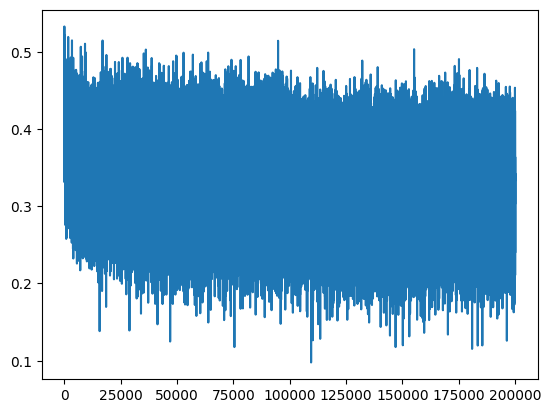

In [62]:
plt.plot(lossi)

In [63]:
@torch.no_grad() # the decorator disables gradient tracking
def split_loss(split):
    x,y = {
        'train': {Xtr, Ytr},
        'val': {Xdev, Ydev},
        'test': {Xte, Yte},
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) #concat into (N, block_size * n_embd)
    hpreact = embcat @ W1 #+ b1
    # used to be thsis, but we added a calibration above: hpreact = (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) # batch-normalization
    # so now it is:
    hpreact = (hpreact - bnmean_running) / bnstd_running # batch-normalization CHANGED
    hpreact = bngain*hpreact + bnbias # added to permit bacprop to scale and shift the distribution, also added to test time
    h = torch.tanh(hpreact) # (N, n_hidden)
    logits = h @ W2 + b2 # N, vocab_size
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0674147605895996
val 2.1056840419769287


In [64]:
# NOTE:
# Also in the Bathc norm paper for the normalisation , there is a constant: ϵ
# it is a small number (e.g. 10**-5) for numerical stability and to avoid division by 0
# this is for the case when variance (std) over our batch is exactly 0 
# epsilon = 10**-5 * torch.ones...
# so we can add it here: hpreact = (hpreact - bnmeani) / (bnstdi + epsilon) # batch-normalization


# IMPORTANT NOTE: adding biases b1 is now useless, because we are shifting everything by -bnmean anway
# so whenever we use Batch Normalization,
# it is better just to not use biases in this layer
# 

# IMPORTANT NOTE:
# We usually place Batch Norm layers after layers with multiplications
# e.g. Linear layer or Convolutional Layers
# 
# BN Layers have "gain" and "bias" parameters, and they are trained by backprop
# also BN has 2 buffers: bnmean_running & bnstd_running - they shuould not be trained
# using backprop, instead they are "trained" with the running average ( actually i think it is EWMA)

In [65]:
# NOTE: fan_in = features_in
# fan_out = features_out

In [66]:
# NOTE
# in PyTorch there is a parameter for batch norm  layer, called "affine", thatdefines, if the
# bngain and bnbias are learnable.
# in our case they are

In [67]:
# Andrej says we have to try to avoid the Batch Normalization as much as possible

In [68]:
# PyTorchifying:

class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in,fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running 'momentum update')
        sel.running_mean = torch.zeros(dim)
        sel.running_var = torch.ones(dim)

    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True) # batch mean
            xvar = x.var(0, keepdim=True, unbiased=True) #batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - mean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
            return self.out

        def parameters(self):
            return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

n_embd = 10 # the dimentionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hiddn layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
    Linear(n_embd * block_size, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, vocab_size),
]

with torch.no_grad():
    # make the last layer to be less confident
    layers[-1].weight += 0.1
    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

46497


In [69]:
# same optimization as last time 
max_steps = 20000
batch_size = 32
lossi = []
ud = [] # update to data info for statistics & debugging

for i in range(max_steps):
    #minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb]
    x = emb.view(emb.shape[0], -1) # concatenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb) # loss function

    # backward pass
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 10000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 99 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    with torch.no_grad():
        ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters]) # if > 0.001 (for log10 == -3), 
        # it is bad, except for the final layer, because we shrank it down by 0.1 at init
        # if it is > -3 (e.g. -1), we need to lower learning rate
        # if it is < -3 (e.g. -5), we need to increase learning rate
        # below is the graph for  MEASURING WHAT LEARNING RATE DOES WITH MODEL
    if i >= 1000:
        break # AFTER DEBUG: would take out obviously to run full optimization                       

      0/  20000: 3.4828
     99/  20000: 2.3108
    198/  20000: 2.2975
    297/  20000: 2.7790
    396/  20000: 2.3770
    495/  20000: 2.2809
    594/  20000: 2.3570
    693/  20000: 2.0649
    792/  20000: 2.3072
    891/  20000: 2.0836
    990/  20000: 2.0943


layer 1 (      Tanh): mean -0.04, std 0.77, saturated: 22.78%
layer 3 (      Tanh): mean -0.01, std 0.73, saturated: 12.03%
layer 5 (      Tanh): mean +0.01, std 0.73, saturated: 12.25%
layer 7 (      Tanh): mean -0.04, std 0.74, saturated: 12.50%
layer 9 (      Tanh): mean -0.01, std 0.73, saturated: 12.66%


Text(0.5, 1.0, 'activation distribution')

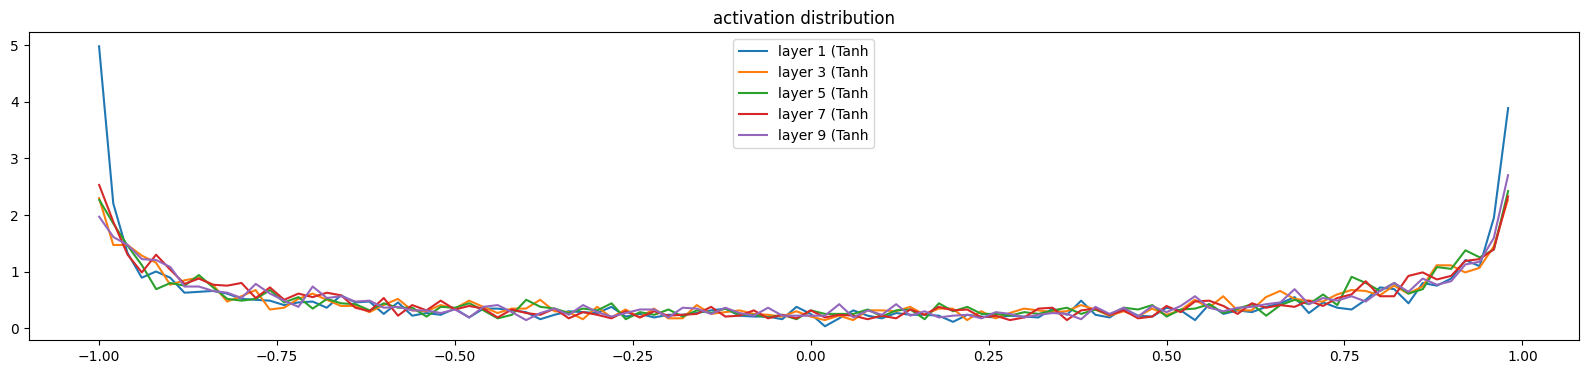

In [70]:
# visualizing for FORWARD PASS
plt.figure(figsize=(20,4)) # w x h of the plot
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

# NOTE: SATURATION STALIBIZES AT ABOUT 5% for a deep net


layer 1 (      Tanh): mean +0.000139, std 3.585985e-03
layer 3 (      Tanh): mean +0.000004, std 3.457584e-03
layer 5 (      Tanh): mean -0.000000, std 3.200078e-03
layer 7 (      Tanh): mean -0.000024, std 3.170735e-03
layer 9 (      Tanh): mean -0.000014, std 2.998191e-03


Text(0.5, 1.0, 'gradient distribution')

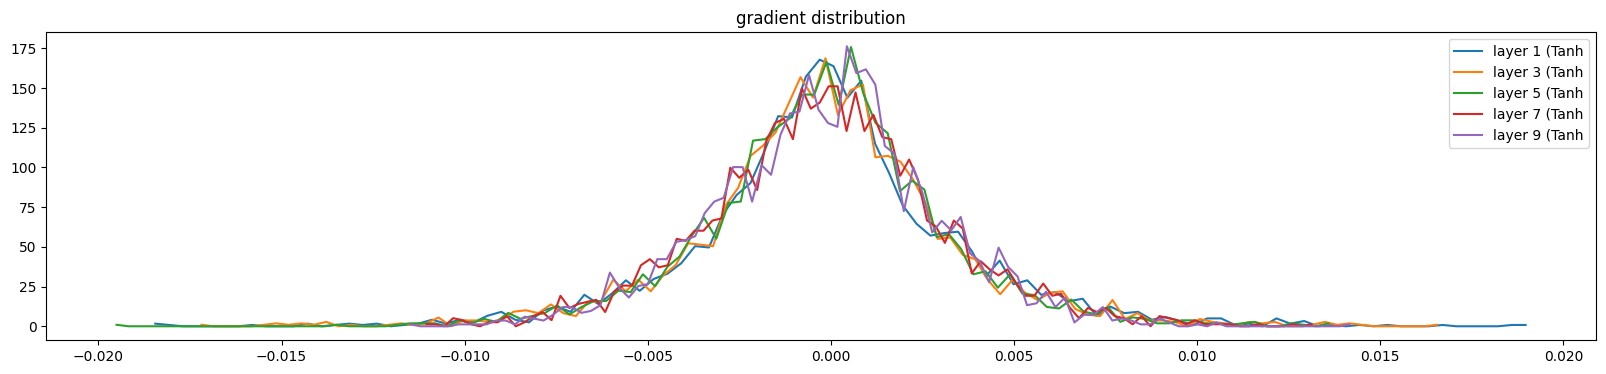

In [71]:
# visualizing for BACKWARD PASS
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')


# NOTE: HERE WE ARE LOKING TO HAVE FOR ALL THE LAYERS ROUGHLY THE SAME GRADIENT
# NOTE: IF WE WOULD REMOVE TANH EVERYWHERE, IT WOULD COLLAPSE TO A SINGLE LINEAR LAYER, IN TERMS OF ITS REPRESENTATION POWER,
# SO BASICALLY THERE IS USUALLY NO REASON FOR HAVING A FEW LINEAR LAYERS STACKED UP, 
# BECAUSE IT IS EQUIVALENT TO A SINGLE LINEAR LAYER 
# NOTE: BUT HAVING A FEW (OR MANY) LINEAR LAYERS STACK UP IN A SANDWITCH - CHANGES the DYNAMICS OF TRAINING
# THERE IS SOME PAPER THAT ANALYSES THIS? INCLUDING STACKING UP INFINITE AMOUNT OF LAYERS.... LINK?
# NOTE Linear + non-linear layers allows to turn a linear fuction into
# a function that can approximate any arbitaraty function ( given that we trained it)

weight   (27, 10) | mean +0.000359 | std 1.149253e-02 | grad:data ratio 1.147236e-02
weight  (30, 100) | mean +0.000222 | std 1.051056e-02 | grad:data ratio 3.351306e-02
weight (100, 100) | mean -0.000033 | std 8.685715e-03 | grad:data ratio 5.147547e-02
weight (100, 100) | mean -0.000038 | std 7.572884e-03 | grad:data ratio 4.459336e-02
weight (100, 100) | mean +0.000041 | std 6.896456e-03 | grad:data ratio 4.085242e-02
weight (100, 100) | mean -0.000040 | std 6.640791e-03 | grad:data ratio 3.947724e-02
weight  (100, 27) | mean +0.000000 | std 1.972175e-02 | grad:data ratio 1.835604e-01


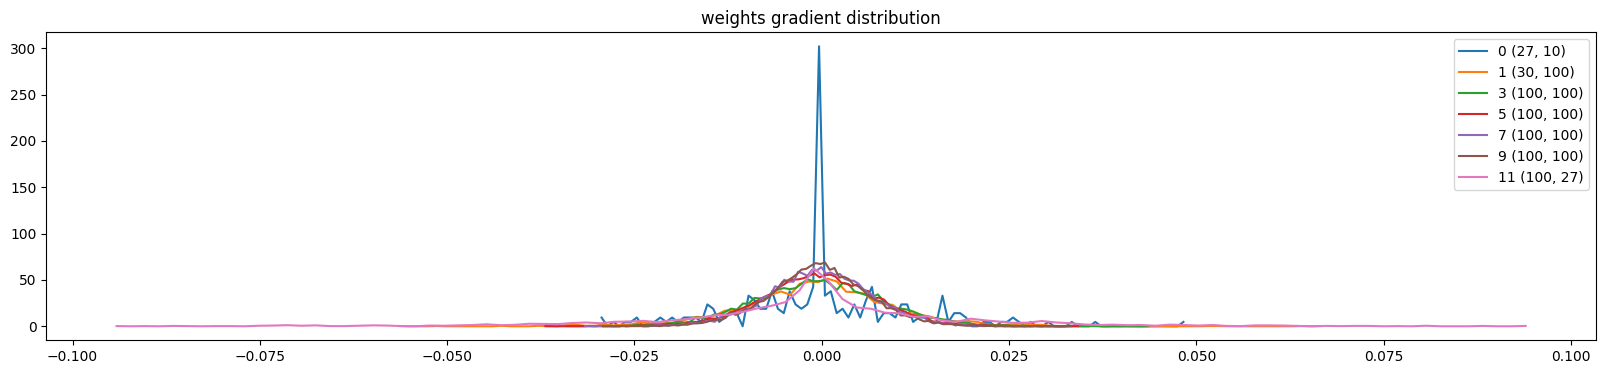

In [72]:
# visualizing ith data to grad ratios
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');


# PARAMETERS, ONLY WEIGHTS (2d here   if p.ndim == 2:), skipping biases, spkipping gammas, betas in bn
# + tracking gradient to data ratio, to understand scale of the gradient, compared to scale of the actual values
# if grad is too large compared to data - it's not gonna train well
# but here the numbers are low
# NOTE: in THE END matters more not the GRADIENT to DATA ratio,
# but the UPDATE to DATA ratio (actual change)

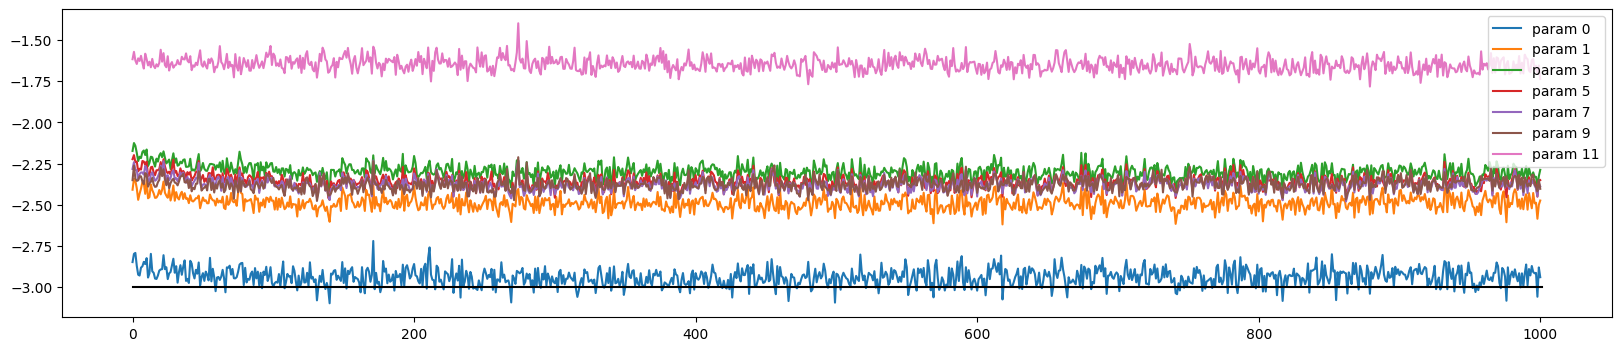

In [73]:
# MEASURING WHAT LEARNING RATE DOES WITH MODEL
# visualizing update to data ratio (the actual changes based on learning rate)
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # NOTE: these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

#constrained to weights only

In [74]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

# put layers into eval mode
for layer in layers:
  layer.training = False
split_loss('train')
split_loss('val')

train 2.3659493923187256
val 2.3715481758117676


In [77]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      x = emb.view(emb.shape[0], -1) # concatenate the vectors
      for layer in layers:
        x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    

In [76]:
# INTRODUCING BATCH NORM WITH INIT ANEW

In [83]:
# PyTorchifying:

class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in,fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True) # batch mean
            xvar = x.var(0, keepdim=True, unbiased=True) #batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
            return self.out

    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

n_embd = 10 # the dimentionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hiddn layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
    Linear(n_embd * block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, vocab_size), BatchNorm1d(vocab_size), 
]

with torch.no_grad():
    # make the last layer to be less confident
    layers[-1].gamma += 0.1
    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

47551


In [84]:
# same optimization as last time 
max_steps = 20000
batch_size = 32
lossi = []
ud = [] # update to data info for statistics & debugging

for i in range(max_steps):
    #minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb]
    x = emb.view(emb.shape[0], -1) # concatenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb) # loss function

    # backward pass
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 10000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 99 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    with torch.no_grad():
        ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters]) # if > 0.001 (for log10 == -3), 
        # it is bad, except for the final layer, because we shrank it down by 0.1 at init
        # if it is > -3 (e.g. -1), we need to lower learning rate
        # if it is < -3 (e.g. -5), we need to increase learning rate
        # below is the graph for  MEASURING WHAT LEARNING RATE DOES WITH MODEL
    if i >= 1000:
        break # AFTER DEBUG: would take out obviously to run full optimization                       

      0/  20000: 3.6833
     99/  20000: 2.6903
    198/  20000: 2.4328
    297/  20000: 2.9367
    396/  20000: 2.3608
    495/  20000: 2.3528
    594/  20000: 2.5345
    693/  20000: 2.1196
    792/  20000: 2.3757
    891/  20000: 2.1853
    990/  20000: 2.2379


layer 2 (      Tanh): mean -0.00, std 0.63, saturated: 2.62%
layer 5 (      Tanh): mean +0.01, std 0.64, saturated: 2.56%
layer 8 (      Tanh): mean -0.01, std 0.65, saturated: 2.12%
layer 11 (      Tanh): mean -0.00, std 0.65, saturated: 1.75%
layer 14 (      Tanh): mean -0.00, std 0.65, saturated: 2.19%


Text(0.5, 1.0, 'activation distribution')

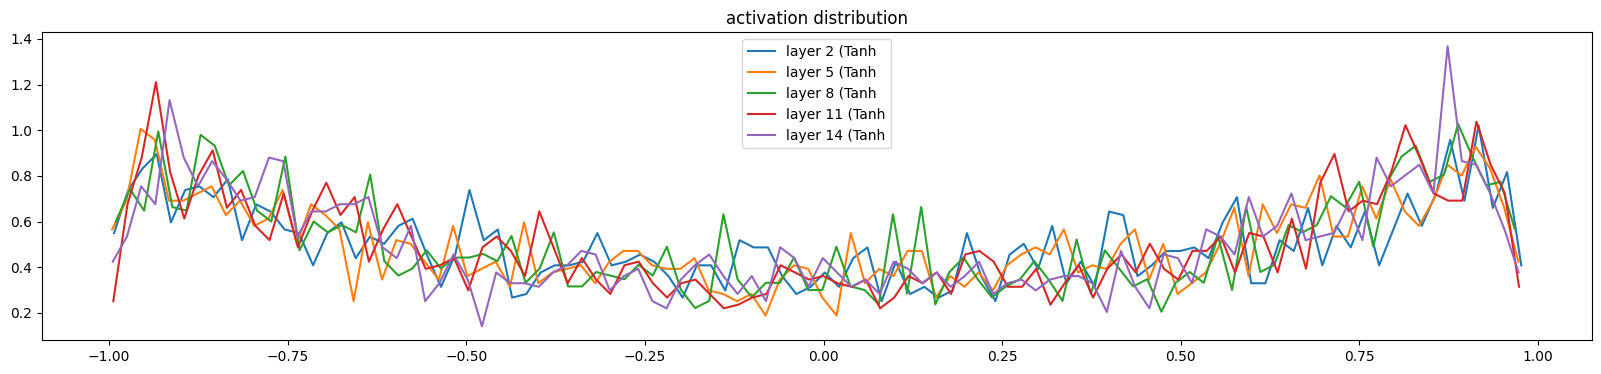

In [85]:
# visualizing for FORWARD PASS
plt.figure(figsize=(20,4)) # w x h of the plot
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

# NOTE: SATURATION STALIBIZES AT ABOUT 5% for a deep net


layer 2 (      Tanh): mean +0.000000, std 3.628047e-03
layer 5 (      Tanh): mean -0.000000, std 3.024878e-03
layer 8 (      Tanh): mean -0.000000, std 2.808876e-03
layer 11 (      Tanh): mean +0.000000, std 2.609616e-03
layer 14 (      Tanh): mean +0.000000, std 2.770632e-03


Text(0.5, 1.0, 'gradient distribution')

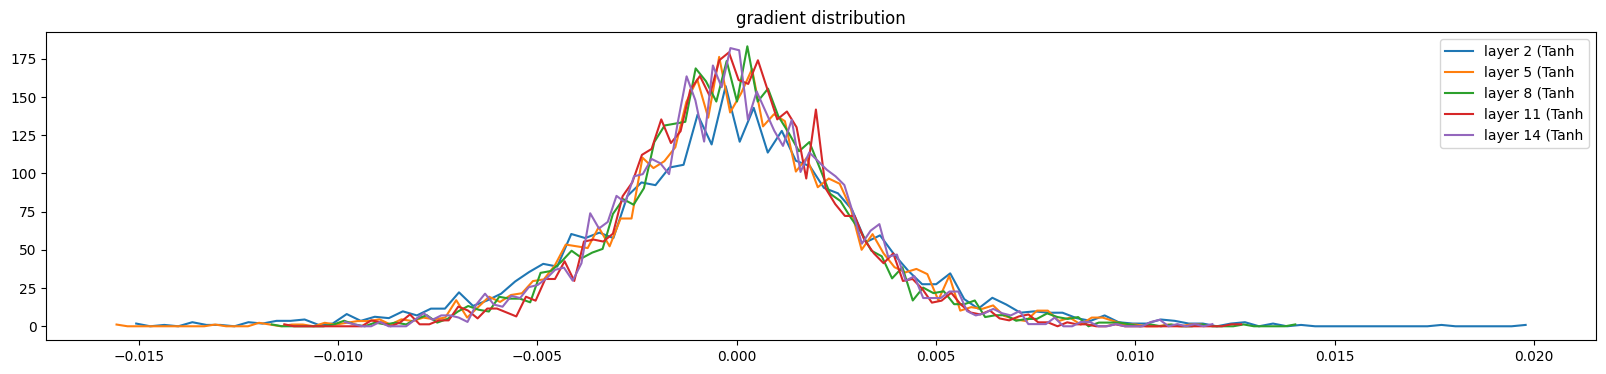

In [86]:
# visualizing for BACKWARD PASS
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')


# NOTE: HERE WE ARE LOKING TO HAVE FOR ALL THE LAYERS ROUGHLY THE SAME GRADIENT
# NOTE: IF WE WOULD REMOVE TANH EVERYWHERE, IT WOULD COLLAPSE TO A SINGLE LINEAR LAYER, IN TERMS OF ITS REPRESENTATION POWER,
# SO BASICALLY THERE IS USUALLY NO REASON FOR HAVING A FEW LINEAR LAYERS STACKED UP, 
# BECAUSE IT IS EQUIVALENT TO A SINGLE LINEAR LAYER 
# NOTE: BUT HAVING A FEW (OR MANY) LINEAR LAYERS STACK UP IN A SANDWITCH - CHANGES the DYNAMICS OF TRAINING
# THERE IS SOME PAPER THAT ANALYSES THIS? INCLUDING STACKING UP INFINITE AMOUNT OF LAYERS.... LINK?
# NOTE Linear + non-linear layers allows to turn a linear fuction into
# a function that can approximate any arbitaraty function ( given that we trained it)

weight   (27, 10) | mean +0.000000 | std 1.110565e-02 | grad:data ratio 1.109145e-02
weight  (30, 100) | mean +0.000190 | std 8.330978e-03 | grad:data ratio 2.660770e-02
weight (100, 100) | mean +0.000010 | std 7.128334e-03 | grad:data ratio 4.245868e-02
weight (100, 100) | mean -0.000037 | std 5.997972e-03 | grad:data ratio 3.545708e-02
weight (100, 100) | mean +0.000033 | std 5.277494e-03 | grad:data ratio 3.135291e-02
weight (100, 100) | mean +0.000005 | std 4.910837e-03 | grad:data ratio 2.917467e-02
weight  (100, 27) | mean -0.000163 | std 1.078099e-02 | grad:data ratio 6.390497e-02


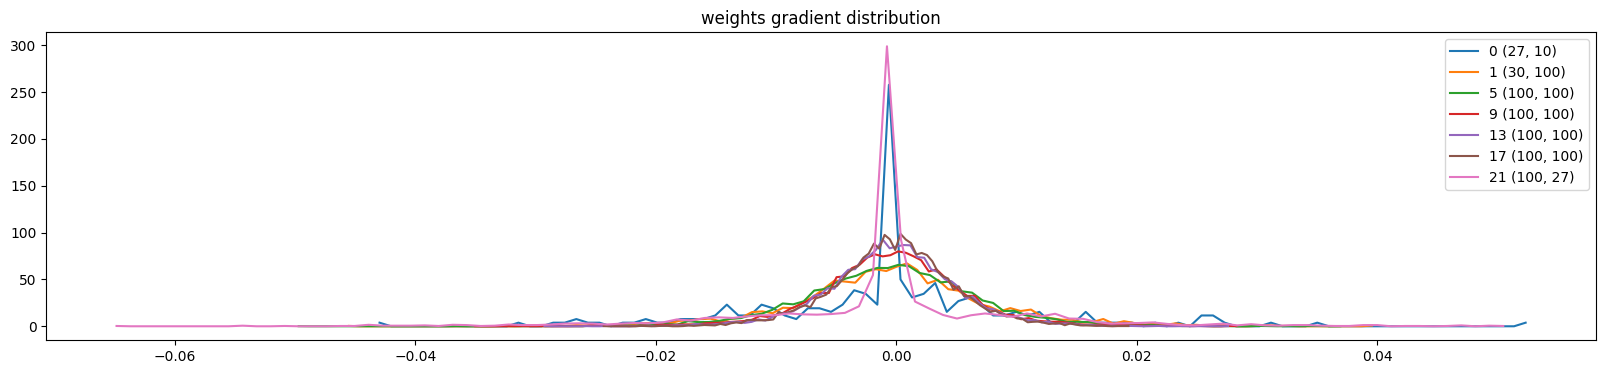

In [87]:
# visualizing ith data to grad ratios
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');


# PARAMETERS, ONLY WEIGHTS (2d here   if p.ndim == 2:), skipping biases, spkipping gammas, betas in bn
# + tracking gradient to data ratio, to understand scale of the gradient, compared to scale of the actual values
# if grad is too large compared to data - it's not gonna train well
# but here the numbers are low
# NOTE: in THE END matters more not the GRADIENT to DATA ratio,
# but the UPDATE to DATA ratio (actual change)

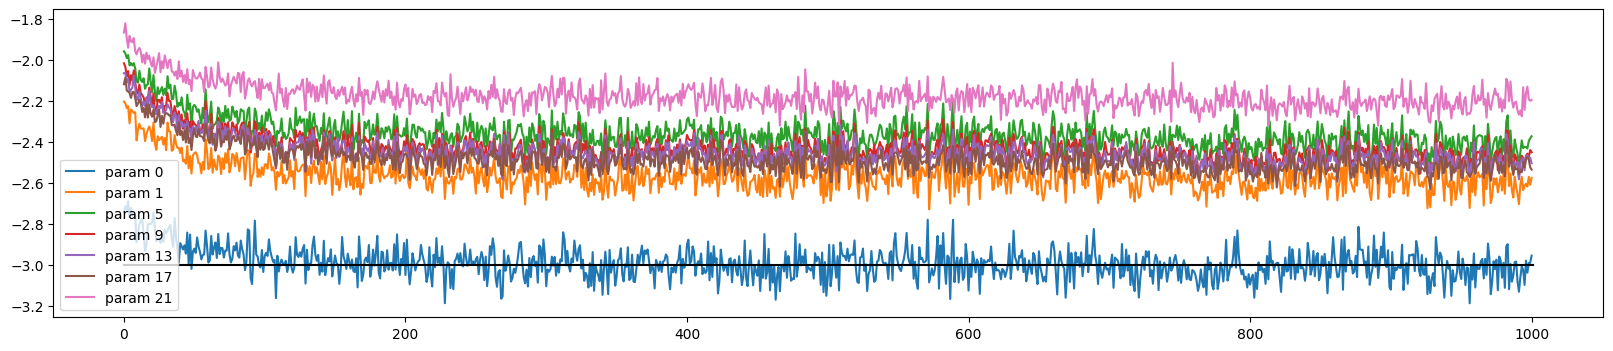

In [88]:
# MEASURING WHAT LEARNING RATE DOES WITH MODEL
# visualizing update to data ratio (the actual changes based on learning rate)
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # NOTE: these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

#constrained to weights only